# A primer on univariate time series regression

The aim of this notebook is to illustrate how we could use univariate time series regression models to make a day ahead forecast of the UK EPEX SPOT Power Price:
https://www.epexspot.com/en/basicspowermarket.

The content of the notebook is purely educational: its interest resides on the process to get to the models, not on the accuracy of the results obtained. 

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot, autocorrelation_plot
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.gofplots import ProbPlot
from sklearn import preprocessing
import warnings

warnings.filterwarnings('ignore')

path = '...'

### 1. Read EPEX SPOT Power Price data

In [2]:
prices = pd.read_csv(path + '/apx_20140101-2020-09-31.csv')
print('Shape of dataframe:', prices.shape)
prices.head()

Shape of dataframe: (118318, 2)


,utc,value
0,2014-01-01 00:00:00+0000,34.1
1,2014-01-01 00:30:00+0000,34.1
2,2014-01-01 01:00:00+0000,34.1
3,2014-01-01 01:30:00+0000,34.1
4,2014-01-01 02:00:00+0000,34.0


In [3]:
# Check for null values
prices.isnull().any()

utc      False
value    False
dtype: bool

In [4]:
# Set variable utc to datetime format and extract some information
prices['utc'] = pd.to_datetime(prices['utc'], utc = True)
prices['date'] = prices['utc'].dt.date
prices['time'] = prices['utc'].dt.time
prices['year'] = prices['utc'].dt.year
prices['month'] = prices['utc'].dt.month
prices['year-month'] = prices['year'].map(str) + '-' + prices['month'].map(str)
prices.head() 

,utc,value,date,time,year,month,year-month
0,2014-01-01 00:00:00+00:00,34.1,2014-01-01,00:00:00,2014,1,2014-1
1,2014-01-01 00:30:00+00:00,34.1,2014-01-01,00:30:00,2014,1,2014-1
2,2014-01-01 01:00:00+00:00,34.1,2014-01-01,01:00:00,2014,1,2014-1
3,2014-01-01 01:30:00+00:00,34.1,2014-01-01,01:30:00,2014,1,2014-1
4,2014-01-01 02:00:00+00:00,34.0,2014-01-01,02:00:00,2014,1,2014-1


In [5]:
# Check month coverage
prices['month'][(prices['year']< 2020) & (prices['year']>= 2015)].value_counts()

12    7440
10    7440
8     7440
7     7440
5     7440
3     7440
1     7440
11    7200
9     7200
6     7200
4     7200
2     6768
Name: month, dtype: int64

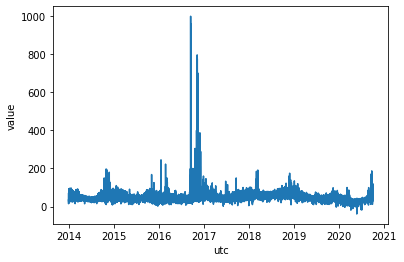

In [6]:
# Let's plot prices over time - it looks quite trendless, with some outliers perhaps some minor seasonality
sns.lineplot(data = prices, x='utc', y='value')
plt.show()

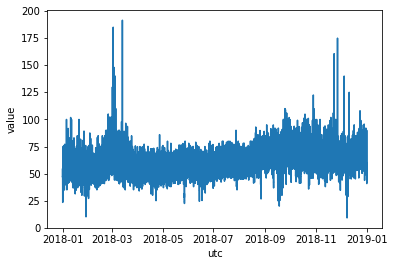

In [7]:
# Zooming into a particular year shows still quite a lot of noise and trendlessness (and self-similarity!)
sns.lineplot(data = prices[(prices['year']==2018)], x='utc', y='value')
plt.show()

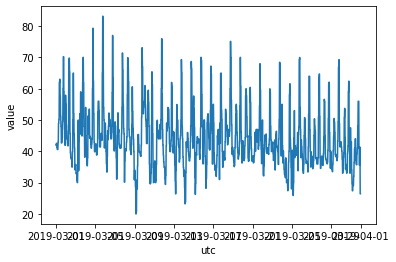

In [8]:
# Montly zooms don't show any particular intra-monthly trend
sns.lineplot(data = prices[(prices['year']==2019) & (prices['month'] == 3)], x='utc', y='value')
plt.show()

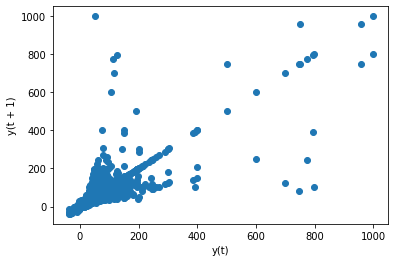

In [9]:
# A quick lag plot shows that there is some autocorrelation in the time series - we'll deal with this more in detail in the model selection section. 
lag_plot(prices['value'])
plt.show()

## 2. ARIMA

In this section, we look at the properties of the prices variable from an [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) perspective. An ARIMA(p, q, s) model (AutoRegressive Integrated Moving Average) is a time series model where the target variable is assumed to be a linear function of it's p lagged values (AR) and some lagged noise up to q time steps (MA). It is integrated of order s if it is necessary to subtract from the value at t the value at t-1 s times.

A linear model will fail to yield good predictions if it's integrated or order >=1. This is equivalent to saying that the model is not covariance-stationary or that it's got a unit root. We can check if our prices present a unit root by running an [Augmented Dickey-Fuller](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) test, as we do below. We include a time trend and a substantial amount of lags (200, or about four days). This makes it harder to reject the null hypothesis of the process having a unit root.

In [10]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(prices['value'], regression = 'ct', maxlag = 200)
adf

(-6.384230457788501,
 3.305649906715562e-07,
 200,
 118117,
 {'1%': -3.9588466472284787,
  '5%': -3.4105271705724296,
  '10%': -3.1270718904411},
 772239.5514720652)

The test statistic is more negative than the p-value, meaning that we reject the null hypothesis of a unit root. A less rich structure of the test, with only a constant in the regression parameter (as opposed to a constant and a time trend) and/or the standard number of lags $12* (\frac{nobs}{100})^{1/4}$ yields the same conclusion.

The plots below show the autocorrelation and partial autocorrelation functions (ACF and PACF, respectively) of the prices variable for 100 lags. Since we have an observation every 30 minutes per day, having 100 lags means that we are seeing slightly over 2 days worth of lags. 

Looking at the ACF, there seems to be quite a sticky correlation, specially around t-48 and t-96 - the same hour of the day before and two days before. Regarding the PACF, it decreases quite quickly after lag 1, although we see some increase around lag 96 as well. 

A good rule of thumb to determine what type of model this could be (in very simple cases) would be the following:
- ARMA(p, 0), or simply AR(p): ACF decreases exponentially, PACF is zero after lag p. 
- ARMA(0, q), or simply MA(q): ACF is zero after lag q, PACF decreases exponential
- ARMA(p, q): both ACF and PACF decrease exponentially. 

Now, ours is not a very simple case, but overall, it looks like the AR part dominates, whilst the MA is not as important. 

Finally, note the fact that the ACF and PACF spike so much in lags 48 and 96 makes me think that the data is somehow stationary, even if this was missed by the ADF. The reason why it was not picked up by the ADF could be that the seasonality is not that clear at higher levels of granularity (days, months). I'll show how to add a seasonal component further down to show a way of dealing with this. 

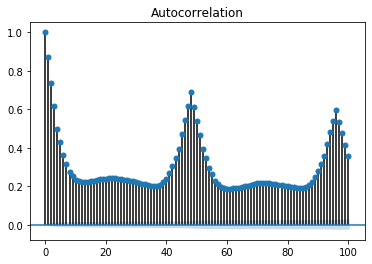

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(prices['value'], lags = '100')
plt.show()

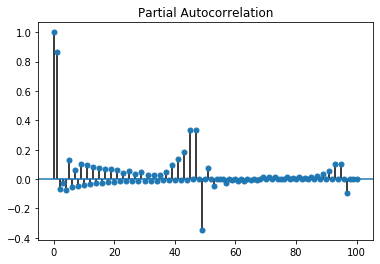

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(prices['value'], lags = '100')
plt.show()

A more formal way to determine what model can be behind the data generation process is to use information criteria. The two most commonly used methods are the [Akaike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) and the [Bayesian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) (AIC and BIC, respectively). Both rely on the [log likelihood](https://en.wikipedia.org/wiki/Likelihood_function) of the model. However, note that the log likelihood of a model is a non-decreasing function of the number of parameters of a model, so very complex models will have larger log likelihood, hence better AIC and BIC, but may overfit and perform badly out of sample. 

Below, we estimate the AIC and BIC of some model specifications and compare the results. I prefer the BIC as it penalises complex models more than AIC, so it prevents overfitting better.   

The purpose of this notebook is not to get to the best possible model, but rather to show how the process of how to get there. Therefore, the models shown below are purely illustrative and better models could be achieved. 

In [13]:
# Split data in train and test set - not random, we take last 48 observations as test (1 day), the rest is train. 
cutoff = len(prices) - 48
train = prices['value'][:cutoff].copy()
test = prices['value'][cutoff:].copy()

In [14]:
# Loop over different combinations of values for p and q in an ARMA(p,q) model (assume s = 0, i.e. the data doesn't have a unit root)
P = [1, 2, 3, 4] # Number of lags of AR part to iterate over
Q = [0, 1, 2] # Number of lags of MA part to iterate over

models = {}
criteria = {}

for q in Q:
    for p in P:

        # Define and train model; store in dicitionary
        model = ARIMA(train, order = (p, 0, q)) 
        result = model.fit() 
        models[(p,q)] = result

        # Get bic and aic; store in dictionary
        bic = result.bic 
        aic = result.aic
        criteria[(p,q)] = {}
        criteria[(p,q)]['aic'] = aic 
        criteria[(p,q)]['bic'] = bic 


According to the AIC and BIC criteria, the best model is the ARMA(4,2), followed by the ARMA(4,1), as shown below. This are the least parsimonious of our models, which is not ideal, but we know that the structure of the data is relatively complex. 

In [15]:
criteria

{(1, 0): {'aic': 851954.9838707446, 'bic': 851984.0260470203},
 (2, 0): {'aic': 851373.0913675905, 'bic': 851411.8142692915},
 (3, 0): {'aic': 851284.7000298534, 'bic': 851333.1036569796},
 (4, 0): {'aic': 850634.3508784823, 'bic': 850692.4352310338},
 (1, 1): {'aic': 851403.3699392593, 'bic': 851442.0928409602},
 (2, 1): {'aic': 851227.7956154401, 'bic': 851276.1992425664},
 (3, 1): {'aic': 840424.62429441, 'bic': 840482.7086469615},
 (4, 1): {'aic': 838390.7565679435, 'bic': 838458.5216459202},
 (1, 2): {'aic': 851347.3783324775, 'bic': 851395.7819596038},
 (2, 2): {'aic': 840448.0325079884, 'bic': 840506.1168605399},
 (3, 2): {'aic': 840512.2958695675, 'bic': 840580.0609475443},
 (4, 2): {'aic': 838283.7745822414, 'bic': 838361.2203856434}}

How do these models fit the training data? Let's have a look at the best two models.

In [16]:
# Put predictions and actuals in same dataframe for convenience
in_sample = pd.DataFrame(columns = ['Actual', 'ARMA(4,2)', 'ARMA(4,1)'], index = prices[0:cutoff].utc)
in_sample['Actual'] = train.values
in_sample['ARMA(4,2)'] = models[(4,2)].fittedvalues.values
in_sample['ARMA(4,1)'] = models[(4,1)].fittedvalues.values

in_sample['utc'] = pd.to_datetime(in_sample.index, utc = True)
in_sample['date'] = in_sample['utc'].dt.date
in_sample['year'] = in_sample['utc'].dt.year

in_sample.head()

,Actual,"ARMA(4,2)","ARMA(4,1)",utc,date,year
utc,,,,,,
2014-01-01 00:00:00+00:00,34.1,43.235058,43.235136,2014-01-01 00:00:00+00:00,2014-01-01,2014
2014-01-01 00:30:00+00:00,34.1,35.298617,35.298120,2014-01-01 00:30:00+00:00,2014-01-01,2014
2014-01-01 01:00:00+00:00,34.1,35.382669,35.382202,2014-01-01 01:00:00+00:00,2014-01-01,2014
2014-01-01 01:30:00+00:00,34.1,35.419014,35.417627,2014-01-01 01:30:00+00:00,2014-01-01,2014
2014-01-01 02:00:00+00:00,34.0,35.528784,35.557725,2014-01-01 02:00:00+00:00,2014-01-01,2014


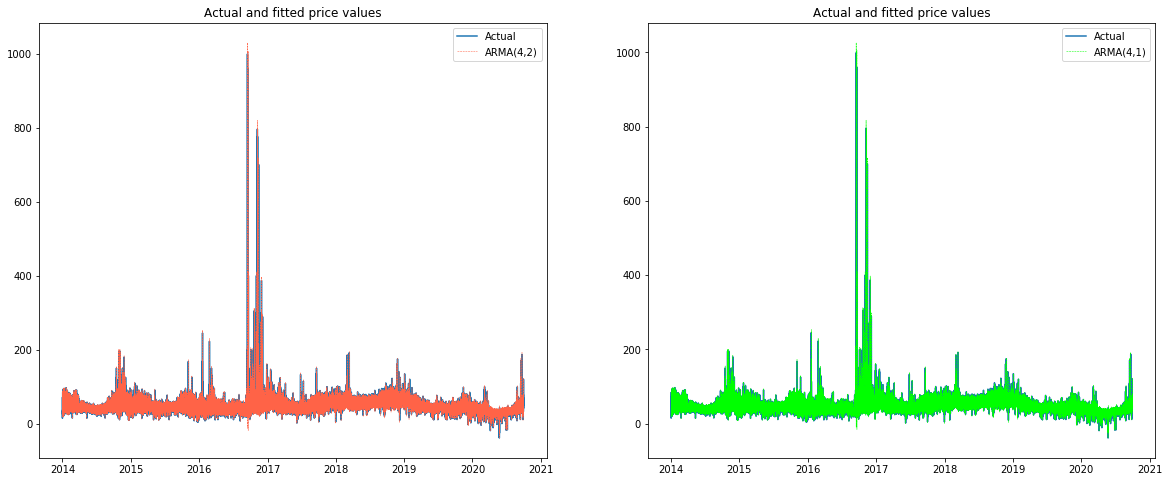

In [17]:
# Plot results and actuals - All training sample
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,8))

ax1.plot(in_sample['Actual'], label = 'Actual')
ax1.plot(in_sample['ARMA(4,2)'], '--', linewidth=0.5, label = 'ARMA(4,2)', color = 'tomato')
ax1.set_title('Actual and fitted price values')


ax2.plot(in_sample['Actual'], label = 'Actual')
ax2.plot(in_sample['ARMA(4,1)'], '--', linewidth=0.5, label = 'ARMA(4,1)', color = 'lime')
ax2.set_title('Actual and fitted price values')

ax1.legend()
ax2.legend()
plt.show()

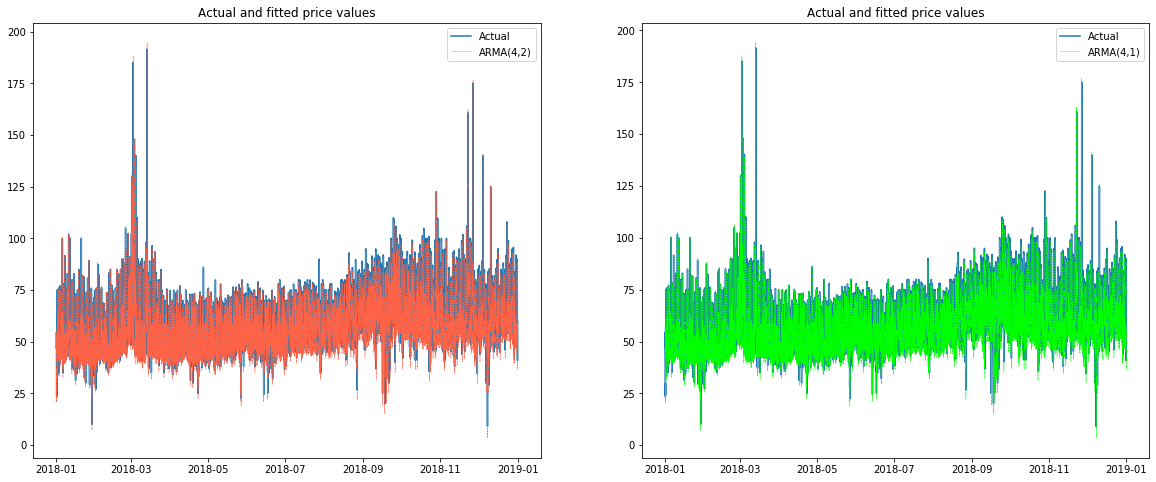

In [18]:
# Plot results and actuals - Selected year
year = 2018
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,8))

ax1.plot(in_sample['Actual'][in_sample['year']==year], label = 'Actual')
ax1.plot(in_sample['ARMA(4,2)'][in_sample['year']==year], '--', linewidth=0.5, label = 'ARMA(4,2)', color = 'tomato')
ax1.set_title('Actual and fitted price values')

ax2.plot(in_sample['Actual'][in_sample['year']==year], label = 'Actual')
ax2.plot(in_sample['ARMA(4,1)'][in_sample['year']==year], '--', linewidth=0.5, label = 'ARMA(4,1)', color = 'lime')
ax2.set_title('Actual and fitted price values')

ax1.legend()
ax2.legend()
plt.show()

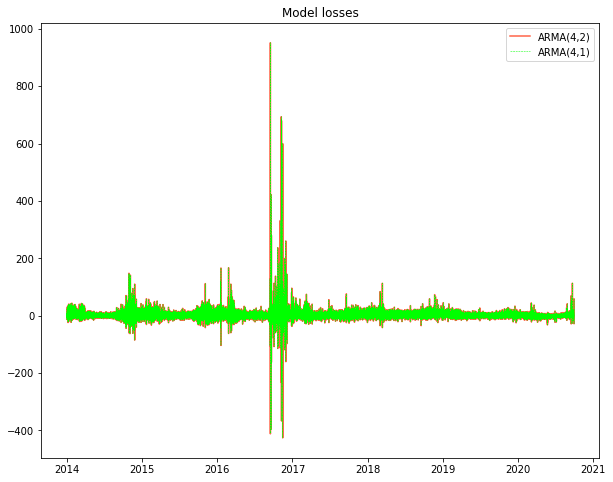

In [19]:
# Model losses
in_sample['loss ARMA(4,2)'] = in_sample['Actual'] - in_sample['ARMA(4,2)']
in_sample['loss ARMA(4,1)'] = in_sample['Actual'] - in_sample['ARMA(4,1)']

fig, ax = plt.subplots(figsize = (10,8))
ax.plot(in_sample['loss ARMA(4,2)'], label = 'ARMA(4,2)', color = 'tomato')
ax.plot(in_sample['loss ARMA(4,1)'], '--', linewidth=0.5, label = 'ARMA(4,1)', color = 'lime')
ax.set_title('Model losses')

ax.legend()
plt.show()


Similarly, the in-sample MSE of each model would be the following:

In [20]:
print('MSE of ARMA(4,2):', models[(4,2)].mse)
print('MSE of ARMA(4,1):', models[(4,1)].mse)

MSE of ARMA(4,2): 70.0948915324014
MSE of ARMA(4,1): 70.15951879190479


Overall, both models seem to replicate the training data well. However, both are unable to predict the volatility around the second half of 2016 and some other smaller clusters. 

One of the implications of our linear model is that, if it fits the data well, then its residuals should be normally distributed and i.i.d. We can already see in the losses chart that the residuals look autocorrelated (the spikes cluster). As we can see in the QQ plots below, the normality condition is not met either - the theoretical quantiles and the sampe quantiles do not form a 45-degree line. This means we should account for a richer model, either with other exogenous regressors or with a better lag structure.

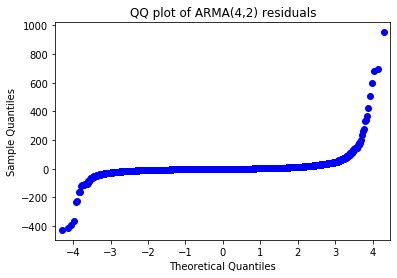

In [21]:
ProbPlot(in_sample['loss ARMA(4,2)']).qqplot()
plt.title('QQ plot of ARMA(4,2) residuals')
plt.show()

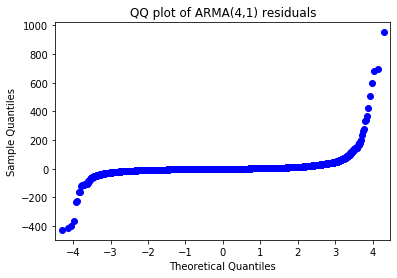

In [22]:
ProbPlot(in_sample['loss ARMA(4,1)']).qqplot()

plt.title('QQ plot of ARMA(4,1) residuals')
plt.show()

What about out-of-sample prediction? 

In [23]:
# Put predictions and actuals in same dataframe for convenience
oo_sample = pd.DataFrame(columns = ['Actual', 'ARMA(4,2)', 'ARMA(4,1)'], index = prices[cutoff:].utc)
oo_sample['Actual'] = test.values
oo_sample['ARMA(4,2)'] = models[(4,2)].predict(cutoff + 1, len(prices)).values
oo_sample['ARMA(4,1)'] = models[(4,1)].predict(cutoff + 1, len(prices)).values

oo_sample['utc'] = pd.to_datetime(oo_sample.index, utc = True)
oo_sample['date'] = oo_sample['utc'].dt.date
oo_sample['year'] = oo_sample['utc'].dt.year


oo_sample.tail()

,Actual,"ARMA(4,2)","ARMA(4,1)",utc,date,year
utc,,,,,,
2020-09-30 20:30:00+00:00,40.95,43.235572,43.235374,2020-09-30 20:30:00+00:00,2020-09-30,2020
2020-09-30 21:00:00+00:00,34.84,43.235478,43.235326,2020-09-30 21:00:00+00:00,2020-09-30,2020
2020-09-30 21:30:00+00:00,34.84,43.235400,43.235288,2020-09-30 21:30:00+00:00,2020-09-30,2020
2020-09-30 22:00:00+00:00,37.44,43.235337,43.235258,2020-09-30 22:00:00+00:00,2020-09-30,2020
2020-09-30 22:30:00+00:00,37.44,43.235286,43.235233,2020-09-30 22:30:00+00:00,2020-09-30,2020


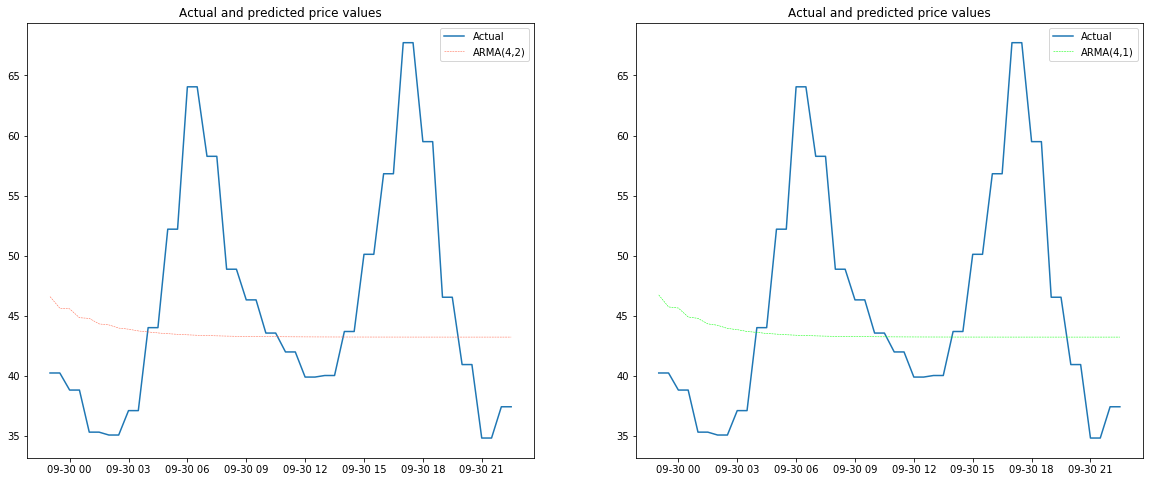

In [24]:
# Plot predictions for next day and actuals
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,8))

ax1.plot(oo_sample['Actual'][0:48], label = 'Actual')
ax1.plot(oo_sample['ARMA(4,2)'][0:48], '--', linewidth=0.5, label = 'ARMA(4,2)', color = 'tomato')
ax1.set_title('Actual and predicted price values')

ax2.plot(oo_sample['Actual'][0:48], label = 'Actual')
ax2.plot(oo_sample['ARMA(4,1)'][0:48], '--', linewidth=0.5, label = 'ARMA(4,1)', color = 'lime')
ax2.set_title('Actual and predicted price values')


ax1.legend()
ax2.legend()
plt.show()

In [25]:
# Out-of-sample MSE
oo_sample['Sq error ARMA(4,2)'] = np.square(oo_sample['Actual'] - oo_sample['ARMA(4,2)'])
oo_sample['Sq error ARMA(4,1)'] = np.square(oo_sample['Actual'] - oo_sample['ARMA(4,1)'])

print('Out-of-sample MSE ARMA (4,2):', np.mean(oo_sample['Sq error ARMA(4,2)']))
print('Out-of-sample MSE ARMA (4,1):', np.mean(oo_sample['Sq error ARMA(4,1)']))

Out-of-sample MSE ARMA (4,2): 95.48083748607142
Out-of-sample MSE ARMA (4,1): 95.65398896389648


We can see that the predictions converge at some point to the unconditional mean of the sample. The out-of-sample MSE is hence larger than the in-sample MSE. This is a characteristic of the ARMA type of models. We can have better predictions by incorporating exogenous variables to our model. These can range from simple trends/cyclical components to weather or power market data.

### 3. SARIMA

A SARIMA model is version of the ARIMA model, but accounting for seasonal effects. In other words, it accounts for periodic events in our data. In our case, these periodic events are the self-similarity of days to one another. To find the appropriate parameters for our SARIMA model, we would need to follow a similar process to the one we followed for our ARMA model. Since I already showed the proces above, I will not do it here. Instead, I will train a simple SARIMA with an AR(1) component both for the seasonal and the non-seasonal components, plus a period of 48 time steps (one day).

In [26]:
# Seasonal model
model = ARIMA(train, order = (1,0,0), seasonal_order = (1,1,0,48)) # AR(1) with a seasonal component which follows itself an AR(1) process every 48 periods (one day)
result = model.fit()

In [27]:
# The AIC, BIC and MSE look better than those of the ARMA models
print('AIC:', result.aic)
print('BIC:', result.bic)
print('MSE:', result.mse)

AIC: 814065.3521497432
BIC: 814094.3931082188
MSE: 57.813674580495395


In [28]:
# Now let's compare with the ARMA 
in_sample['SARIMA'] = result.fittedvalues.values
in_sample['loss SARIMA'] = in_sample['Actual'] - in_sample['SARIMA']
oo_sample['SARIMA'] = result.predict(cutoff + 1, len(prices)).values


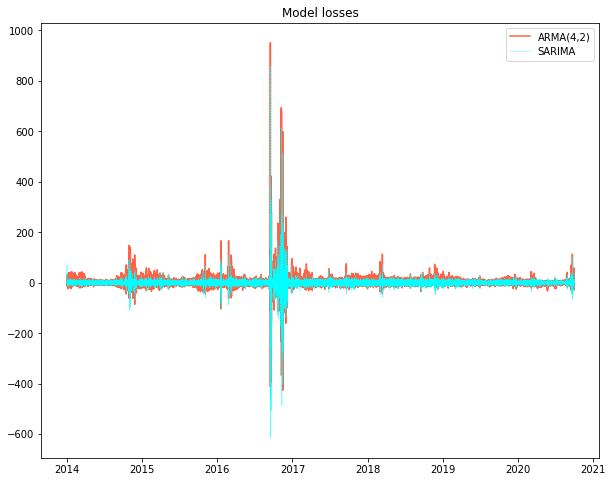

In [29]:
# Plot model losses compared to best ARMA (4,2)
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(in_sample['loss ARMA(4,2)'], label = 'ARMA(4,2)', color = 'tomato')
ax.plot(in_sample['loss SARIMA'], '--', linewidth=0.5, label = 'SARIMA', color = 'cyan')
ax.set_title('Model losses')

ax.legend()
plt.show()


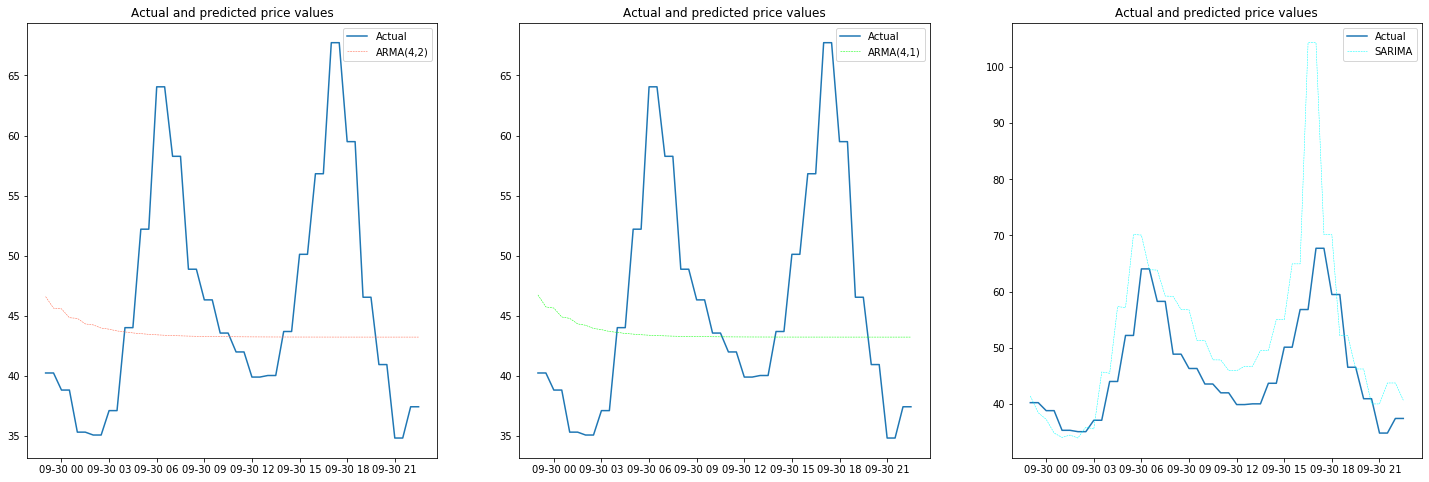

In [30]:
# Plot predictions for next day and actuals
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(25,8))

ax1.plot(oo_sample['Actual'][0:48], label = 'Actual')
ax1.plot(oo_sample['ARMA(4,2)'][0:48], '--', linewidth=0.5, label = 'ARMA(4,2)', color = 'tomato')
ax1.set_title('Actual and predicted price values')

ax2.plot(oo_sample['Actual'][0:48], label = 'Actual')
ax2.plot(oo_sample['ARMA(4,1)'][0:48], '--', linewidth=0.5, label = 'ARMA(4,1)', color = 'lime')
ax2.set_title('Actual and predicted price values')

ax3.plot(oo_sample['Actual'][0:48], label = 'Actual')
ax3.plot(oo_sample['SARIMA'][0:48], '--', linewidth=0.5, label = 'SARIMA', color = 'cyan')
ax3.set_title('Actual and predicted price values')


ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

In [31]:
# Out-of-sample MSE
oo_sample['Sq error SARIMA'] = np.square(oo_sample['Actual'] - oo_sample['SARIMA'])

print('Out-of-sample SARIMA:', np.mean(oo_sample['Sq error SARIMA']))

Out-of-sample SARIMA: 120.82016245040161


It looks like the SARIMA model produces better looking results than the ARMA models: the model losses are much smaller in sample, and it tracks the seasonal variation out of sample. However, it performs worse out of sample when it comes to MSE. We can see that it has overestimated most of the values. We could still improve the model with exogenous regressors such as power market and weather data, but that is outside the scope of this notebook.